We **need to find the best zone for recreation in a city** .So the travellers get all the things they need nearby.

We are besically using follium maps and clustering methods with decision trees with special focus on latency.


In [0]:
import requests
import json
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from sklearn.cluster import KMeans 
from sklearn.preprocessing import LabelEncoder
from scipy.spatial.distance import cdist
import numpy as np

 ## **Define your Foursquare credentials here**

In [0]:
CLIENT_ID="LIQI3OWFMIVHIADQEAFCHAT55AW5DSOJU4AIXTBYVFDKN04H"
CLIENT_SECRET="G4JDBVDY5MUQZBUW4WLSADMJBTWD3LRVUSU5ZXFJPJL1JQVX"
#Delhi
LAT_LNG="28.644800,77.216721"

## **To get venues**

In [0]:
def get_venues(LAT_LNG,CLIENT_ID,CLIENT_SECRET):
  res = requests.get("https://api.foursquare.com/v2/venues/search?ll="+LAT_LNG+"&client_id="+CLIENT_ID+"&client_secret="+CLIENT_SECRET+"&v=20200510")
  if(res.status_code==200):
    return res.content
  else:
    return None

## **Parse the data into JSON and convert it into the df**

****

In [485]:
raw=get_venues(LAT_LNG,CLIENT_ID,CLIENT_SECRET)
data=json.loads(raw)["response"]["venues"]
res_df=pd.read_json(json.dumps(data))
res_df.head()

,id,name,location,categories,referralId,hasPerk,venuePage
0,5df931d140c87e00088f2223,Hotel Ritz,"{'address': '8567 Arakashan Road, Paharganj Be...","[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1587044330,False,NaN
1,548a6de3498ecb54da9adac2,Burger King,"{'address': 'E8 Inner Circle', 'crossStreet': ...","[{'id': '4bf58dd8d48988d16e941735', 'name': 'F...",v-1587044330,False,NaN
2,52baa97011d25e5925f2a55a,Shiela Cinema,"{'lat': 28.644815157515968, 'lng': 77.21690750...","[{'id': '4bf58dd8d48988d17f941735', 'name': 'M...",v-1587044330,False,NaN
3,54f84ede498eae1662c04df0,The Prime Balaji Deluxe @ New Delhi Railway St...,"{'address': '8574 Arakashan Road Pahar Ganj', ...","[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1587044330,False,NaN
4,4ea2ff0677c8d0ce5e2f034e,Vijaya Bank ATM,"{'lat': 28.644741004025168, 'lng': 77.21800786...","[{'id': '4bf58dd8d48988d10a951735', 'name': 'B...",v-1587044330,False,NaN


 ## **Get the df and we need 4 attribues for clustering**


1.   id
2.   type
3.   lat
4.   lng

We will use res_df for mapping our needs with the loc.

In [486]:
def get_id_lat_lng_type(base_df):
  arr=[]
  for index,row in base_df.iterrows():
    group_df=row
    if(len(group_df["categories"])>0):
      category=group_df["categories"][0]["name"].lower()
      id=group_df["id"]
      lat=group_df["location"]["lat"]
      lng=group_df["location"]["lng"]
      name=group_df["name"]
      arr.append({'id':id,"name":name,'category':category,'lat':lat,'lng':lng})
  df=pd.read_json(json.dumps(arr))
  return df
processed_df=get_id_lat_lng_type(res_df)
processed_df.head()

,id,name,category,lat,lng
0,5df931d140c87e00088f2223,Hotel Ritz,hotel,28.645359,77.216879
1,548a6de3498ecb54da9adac2,Burger King,fast food restaurant,28.632828,77.221326
2,52baa97011d25e5925f2a55a,Shiela Cinema,movie theater,28.644815,77.216908
3,54f84ede498eae1662c04df0,The Prime Balaji Deluxe @ New Delhi Railway St...,hotel,28.645247,77.217433
4,4ea2ff0677c8d0ce5e2f034e,Vijaya Bank ATM,bank,28.644741,77.218008


## **Let's view in the follium map**

In [0]:
coord=LAT_LNG.split(",")
map = folium.Map(location=[float(coord[0]),float(coord[1])],tiles='OpenStreetMap')

marker_cluster = MarkerCluster().add_to(map)
for index,row in processed_df.iterrows():
    folium.Marker([row["lat"],row["lng"]], popup=row["name"]).add_to(marker_cluster)


In [488]:
map

## **Group**  
Now we need to group the data based on category 

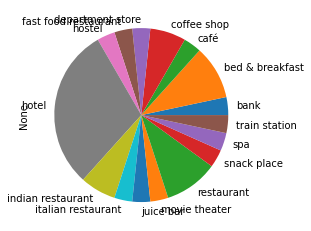

In [489]:
processed_df.groupby('category').size().plot(kind='pie')

In [490]:
processed_df.groupby('category').size().sort_values(ascending=False)

category
hotel                   9
restaurant              3
bed & breakfast         3
indian restaurant       2
coffee shop             2
train station           1
spa                     1
snack place             1
movie theater           1
juice bar               1
italian restaurant      1
hostel                  1
fast food restaurant    1
department store        1
café                    1
bank                    1
dtype: int64

## **Label encoding of the category**

In [0]:
le = LabelEncoder() 
processed_df['category']= le.fit_transform(processed_df['category']) 

In [492]:
processed_df.head()

,id,name,category,lat,lng
0,5df931d140c87e00088f2223,Hotel Ritz,7,28.645359,77.216879
1,548a6de3498ecb54da9adac2,Burger King,5,28.632828,77.221326
2,52baa97011d25e5925f2a55a,Shiela Cinema,11,28.644815,77.216908
3,54f84ede498eae1662c04df0,The Prime Balaji Deluxe @ New Delhi Railway St...,7,28.645247,77.217433
4,4ea2ff0677c8d0ce5e2f034e,Vijaya Bank ATM,0,28.644741,77.218008


**For the time being I have taken K =4 how ever we can use elbow method or find the number of unique regions and set the value of K accordingly**

No handles with labels found to put in legend.


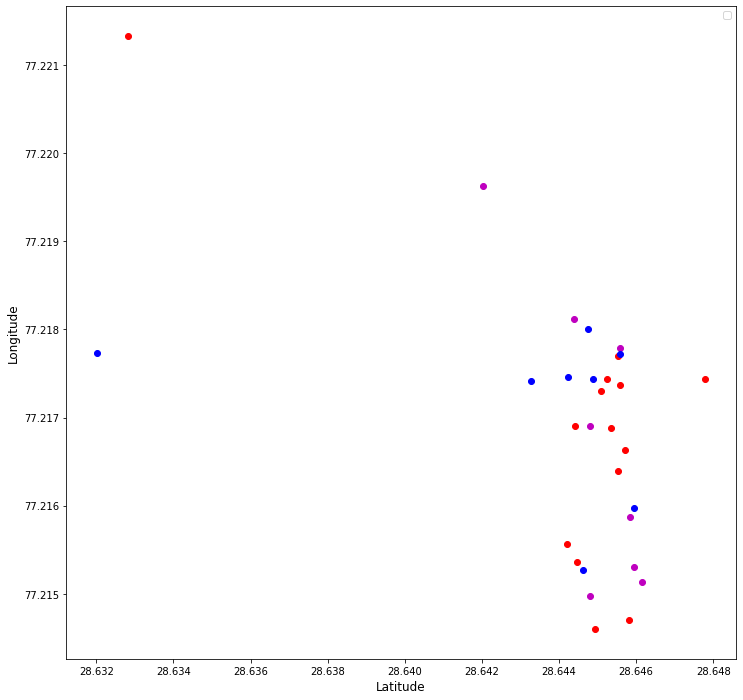

In [493]:
K=3
kmeans = KMeans(n_clusters =K)
df=processed_df[::]
del df["id"]
del df["name"]
kmeans.fit(df)
label_index=kmeans.labels_

ptsymb = np.array(['b','r','m','g','c','k']);
plt.figure(figsize=(12,12))
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
for index,row in df.iterrows():
    color=ptsymb[label_index[index]]
    plt.plot(row["lat"],row["lng"],marker='o',color=color)
plt.legend(numpoints=1)    
plt.show()

## **Analyze each cluster and create a matrix**
The y axis is the k value ( groups)  
The x axis is the services count 

In [494]:
matrix={}
for index in label_index:
  matrix[str(index)]=[0]*len(le.classes_)
for index,row in processed_df.iterrows():
  group=str(label_index[index])
  key=row["category"]
  matrix[group][key]=matrix[group][key]+1
mat=pd.read_json(json.dumps(matrix))
mat=mat.transpose()
print(mat)

   0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15
1  0  0  0  0  0  1  1  9  2  1   0   0   0   0   0   0
2  0  0  0  0  0  0  0  0  0  0   1   1   3   1   1   1
0  1  3  1  2  1  0  0  0  0  0   0   0   0   0   0   0


In [495]:
print(le.classes_)

['bank' 'bed & breakfast' 'café' 'coffee shop' 'department store'
 'fast food restaurant' 'hostel' 'hotel' 'indian restaurant'
 'italian restaurant' 'juice bar' 'movie theater' 'restaurant'
 'snack place' 'spa' 'train station']


## **Measure it's skewness and get the best cluster**

In [496]:
result=mat.skew(axis = 1).sort_values(ascending = True)
print(result)

0    1.916630
2    2.099563
1    3.561212
dtype: float64


In [497]:
data=json.loads(result.to_json())
best_cluster=None
for key,value in enumerate(data):
  best_cluster=int(value)
  break
print("Best cluser is in index at "+str(best_cluster))

Best cluser is in index at 0


## **Show the area in the follium map**

In [0]:
#get the regions from the processed_df
coord=LAT_LNG.split(",")
map2 = folium.Map(location=[float(coord[0]),float(coord[1])],tiles='OpenStreetMap')

marker_cluster = MarkerCluster().add_to(map2)
    
for index,row in processed_df.iterrows():
  group=label_index[index]
  if(group==best_cluster):
    #display it on the map.
    folium.Marker([row["lat"],row["lng"]], popup=row["name"]).add_to(marker_cluster)

*Suggested area is shown on the map ,so you can book your stay nearby this location to leverage the best the city can give you*  
The markes shown here are the diffrent types of recreational spots.

In [499]:
map2